# Saving and Loading Models

Loading previously trained models to:
- Making predictions
- Continue training on new data

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper
import fc_model

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [3]:
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, \
                                train=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


In [4]:
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, \
                                train=False, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


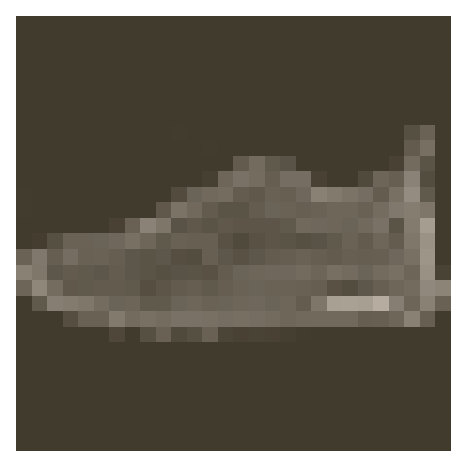

In [5]:
image, label = next(iter(trainloader))
helper.imshow(image[0, :])

## Train a network

In [6]:
n_features = 784
n_classes = 10
model = fc_model.Network(n_features, n_classes, [128, 32], 0.2)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
fc_model.train(model, trainloader, testloader, criterion, optimizer,
          epochs=2, print_every=200)

Epoch: 1/2..  Training Loss: 0.943..  Test Loss: 0.575..  Test Accuracy: 0.787
Epoch: 1/2..  Training Loss: 0.611..  Test Loss: 0.508..  Test Accuracy: 0.812
Epoch: 1/2..  Training Loss: 0.549..  Test Loss: 0.476..  Test Accuracy: 0.825
Epoch: 1/2..  Training Loss: 0.528..  Test Loss: 0.462..  Test Accuracy: 0.832
Epoch: 2/2..  Training Loss: 0.476..  Test Loss: 0.469..  Test Accuracy: 0.828
Epoch: 2/2..  Training Loss: 0.480..  Test Loss: 0.449..  Test Accuracy: 0.835
Epoch: 2/2..  Training Loss: 0.455..  Test Loss: 0.448..  Test Accuracy: 0.831
Epoch: 2/2..  Training Loss: 0.445..  Test Loss: 0.430..  Test Accuracy: 0.844
Epoch: 2/2..  Training Loss: 0.442..  Test Loss: 0.423..  Test Accuracy: 0.847


## Saving and loading networks

- It's impractical to train a network everytime you need to use it -> Save trained networks then load them later
- Parameters for Pytorch networks are stored in a model's `state_dict`

In [8]:
model

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=32, bias=True)
  )
  (output): Linear(in_features=32, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

In [9]:
model.state_dict().keys()

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'output.weight', 'output.bias'])

Save the state dict with `torch.save`, load with `torch.load`, and bind parameters of model with state dict with `model.load_state_dict` 

In [10]:
torch.save(model.state_dict(), 'ckpoint.pth')

In [11]:
state_dict = torch.load('ckpoint.pth')

In [12]:
state_dict.keys()

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'output.weight', 'output.bias'])

In [13]:
# load state dict into the network:
model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

When binding parameters from state dict to model, model **must have the same architecture** with the state dict checkpoint

In [14]:
model = fc_model.Network(n_features, n_classes, [256, 32])
# try to load state dict to a different architecture
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Network:
	size mismatch for hidden_layers.0.weight: copying a param with shape torch.Size([128, 784]) from checkpoint, the shape in current model is torch.Size([256, 784]).
	size mismatch for hidden_layers.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for hidden_layers.1.weight: copying a param with shape torch.Size([32, 128]) from checkpoint, the shape in current model is torch.Size([32, 256]).

- We need to rebuild the model exactly as it was when trained
- **Information about the model architecture needs to be saved** in the checkpoint, along with the state dict

In [15]:
checkpoints = {
    'input_size': 784,
    'output_size': 10,
    'hidden_layers': [each.out_features for each in model.hidden_layers],
    'state_dict': model.state_dict()
}

In [16]:
torch.save(checkpoints, 'ckpoint.pth')

In [17]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [18]:
model = load_checkpoint('ckpoint.pth')

In [19]:
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=32, bias=True)
  )
  (output): Linear(in_features=32, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)
